<a href="https://colab.research.google.com/github/Amirhk-dev/MNIST-Lab/blob/main/experiments/notebooks/transformers/GPT_Dev_MNIST_Generate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#This notebook is relevant to the prior notebook in [text generation](https://github.com/Amirhk-dev/MNIST-Lab/blob/main/experiments/notebooks/transformers/GPT_Dev_Text_Generate.ipynb).

Here, the focus is on [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database) (containing handwritten digits). 

The simple version of the transformer is trained on first 9K images of this dataset.

The model must be trained on GPU because otherwise it will take ages to train. At inference time, using CPU will be sufficient.

Goal: the goal is to make a pre-trained transformer to generate similar images to MNIST images.

In [1]:
import os
import torch
import torch.nn as nn
from torch.nn import functional as F

from torchvision import datasets
import torchvision.transforms as transforms

import urllib.request
from urllib.error import HTTPError

import numpy as np
import matplotlib.pyplot as plt

In [2]:
gpu_availability = torch.cuda.is_available()
print(f"Is the GPU available? {gpu_availability}")

Is the GPU available? False


In [3]:
device = torch.device("cuda") if gpu_availability else torch.device("cpu")
print(f"The using device is: {device}")

The using device is: cpu


In [4]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.MNIST('datasets/MNIST',
                               transform = transform,
                               download = True,
                               train = True)

train_set, val_set = torch.utils.data.random_split(train_dataset,
                                                   [50000, 10000])

Visualisation of 10 images on the trainset of MNIST dataset

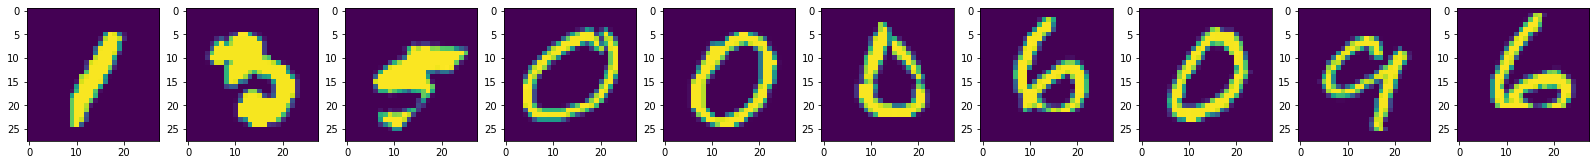

In [12]:
fig = plt.figure(figsize=(28, 28))
for i in range(1, 11):
    img = train_set[i][0][0]
    fig.add_subplot(1, 10, i)
    plt.imshow(img)
plt.show()

Considering pixel values in an image as being characters on a text!

The end of an image is shown by an integer 1000.

In [11]:
train_data = []
counter = 0
for idx in range(len(train_set)):
  img = train_set[idx][0][0]
  a = img.reshape(-1)
  train_data.extend(a)
  train_data.extend([1000])
  
  if counter > 10000:
    break
  
  counter += 1

In [13]:
max_iters = 7000
learning_rate = 3e-4
dropout = 0.2
batch_size = 64 # how many independent sequences will we process in parallel?
block_size = 256 # what is the maximum context length for predictions?
eval_interval = 500
eval_iters = 200
n_embd = 384
n_head = 6
n_layer = 6

CHECKPOINT_PATH = "./"

In [14]:
torch.manual_seed(42) # 42 = 101010

In [15]:
# here are all the unique pixel values that occur in the images
chars = np.unique(train_data)
vocab_size = len(chars)
print("number of different characters: ", vocab_size)

# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[float(c)] for c in s] 
decode = lambda l: [itos[i] for i in l]

number of different characters:  257


In [16]:
print(stoi)

{0.0: 0, 0.003921568859368563: 1, 0.007843137718737125: 2, 0.0117647061124444: 3, 0.01568627543747425: 4, 0.019607843831181526: 5, 0.0235294122248888: 6, 0.027450980618596077: 7, 0.0313725508749485: 8, 0.03529411926865578: 9, 0.03921568766236305: 10, 0.04313725605607033: 11, 0.0470588244497776: 12, 0.05098039284348488: 13, 0.054901961237192154: 14, 0.05882352963089943: 15, 0.062745101749897: 16, 0.06666667014360428: 17, 0.07058823853731155: 18, 0.07450980693101883: 19, 0.0784313753247261: 20, 0.08235294371843338: 21, 0.08627451211214066: 22, 0.09019608050584793: 23, 0.0941176488995552: 24, 0.09803921729326248: 25, 0.10196078568696976: 26, 0.10588235408067703: 27, 0.10980392247438431: 28, 0.11372549086809158: 29, 0.11764705926179886: 30, 0.12156862765550613: 31, 0.125490203499794: 32, 0.12941177189350128: 33, 0.13333334028720856: 34, 0.13725490868091583: 35, 0.1411764770746231: 36, 0.14509804546833038: 37, 0.14901961386203766: 38, 0.15294118225574493: 39, 0.1568627506494522: 40, 0.16078

In [17]:
print(itos)

{0: 0.0, 1: 0.003921568859368563, 2: 0.007843137718737125, 3: 0.0117647061124444, 4: 0.01568627543747425, 5: 0.019607843831181526, 6: 0.0235294122248888, 7: 0.027450980618596077, 8: 0.0313725508749485, 9: 0.03529411926865578, 10: 0.03921568766236305, 11: 0.04313725605607033, 12: 0.0470588244497776, 13: 0.05098039284348488, 14: 0.054901961237192154, 15: 0.05882352963089943, 16: 0.062745101749897, 17: 0.06666667014360428, 18: 0.07058823853731155, 19: 0.07450980693101883, 20: 0.0784313753247261, 21: 0.08235294371843338, 22: 0.08627451211214066, 23: 0.09019608050584793, 24: 0.0941176488995552, 25: 0.09803921729326248, 26: 0.10196078568696976, 27: 0.10588235408067703, 28: 0.10980392247438431, 29: 0.11372549086809158, 30: 0.11764705926179886, 31: 0.12156862765550613, 32: 0.125490203499794, 33: 0.12941177189350128, 34: 0.13333334028720856, 35: 0.13725490868091583, 36: 0.1411764770746231, 37: 0.14509804546833038, 38: 0.14901961386203766, 39: 0.15294118225574493, 40: 0.1568627506494522, 41: 0.1

In [18]:
# train and test splits
data = torch.tensor(encode(train_data), dtype=torch.long)

# Let's now split up the data into train and validation sets
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

In [19]:
# data loading
def get_batch(split):
  # generate a small batch of inputs x and targets y
  data = train_data if split == 'train' else val_data
  ix = torch.randint(len(data) - block_size, (batch_size,))
  x = torch.stack([data[i:i+block_size] for i in ix])
  y = torch.stack([data[i+1:i+block_size+1] for i in ix])
  x, y = x.to(device), y.to(device)
  return x, y

In [20]:
@torch.no_grad()
def estimate_loss():
  out = {}
  model.eval()
  for split in ['train', 'val']:
    losses = torch.zeros(eval_iters)
    for k in range(eval_iters):
      X, Y = get_batch(split)
      logits, loss = model(X, Y)
      losses[k] = loss.item()
    out[split] = losses.mean()
  model.train()
  return out

In [21]:
class Head(nn.Module):
  """ one head of self-attention """

  def __init__(self, head_size):
    super().__init__()
    self.key = nn.Linear(n_embd, head_size, bias=False)
    self.query = nn.Linear(n_embd, head_size, bias=False)
    self.value = nn.Linear(n_embd, head_size, bias=False)
    self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    B, T, C = x.shape
    k = self.key(x) # (B, T, C)
    q = self.query(x) # (B, T, C)
    # compute attention scores ("affinities")
    wei = q @ k.transpose(-2, -1) * C**-0.5 # (B, T, C) @ (B, C, T) --> (B, T, T)
    wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
    wei = F.softmax(wei, dim=-1) # (B, T, T)
    wei = self.dropout(wei)
    # perform the weighted aggregation of the values
    v = self.value(x)
    out = wei @ v # (B, T, T) @ (B, T, C) --> (B, T, C)
    return out

In [22]:
class MultiHeadAttention(nn.Module):
  """ multiple heads of self-attention in parallel """

  def __init__(self, num_heads, head_size):
    super().__init__()
    self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
    self.proj = nn.Linear(n_embd, n_embd)
    self.dropout = nn.Dropout(dropout) 

  def forward(self, x):
    out = torch.cat([h(x) for h in self.heads], dim=-1)
    out = self.dropout(self.proj(out))
    return out

In [23]:
class FeedForward(nn.Module):
  """ a simple linear layer followed by a non-linearity """

  def __init__(self, n_embd):
    super().__init__()
    self.net = nn.Sequential(
        nn.Linear(n_embd, 4 * n_embd),
        nn.ReLU(),
        nn.Linear(4 * n_embd, n_embd),
        nn.Dropout(dropout),
    )

  def forward(self, x):
    return self.net(x)

In [24]:
class Block(nn.Module):
  """ Transformer block: communication followed by computation """

  def __init__(self, n_embd, n_head):
    # n_embd: embedding dimension, n_head: the number of heads we'd like
    super().__init__()
    head_size = n_embd // n_head
    self.sa = MultiHeadAttention(n_head, head_size)
    self.ffwd = FeedForward(n_embd)
    self.ln1 = nn.LayerNorm(n_embd)
    self.ln2 = nn.LayerNorm(n_embd)

  def forward(self, x):
    x = x + self.sa(self.ln1(x))
    x = x + self.ffwd(self.ln2(x))
    return x

In [25]:
# super simple bigram model
class BigramLanguageModel(nn.Module):

  def __init__(self):
    super().__init__()
    # each token directly reads off the logits for the next token from a lookup table
    self.token_embedding_table = nn.Embedding(vocab_size, n_embd) # n_embd: number of embedding dimensions
    self.position_embedding_table = nn.Embedding(block_size, n_embd)
    self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
    self.ln_f = nn.LayerNorm(n_embd) # final layer norm    
    self.lm_head = nn.Linear(n_embd, vocab_size)

  def forward(self, idx, targets=None):

    B, T = idx.shape

    # idx and targets are both (B, T) tensor of integers
    tok_emb = self.token_embedding_table(idx) # (B, T, C)
    pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T, C)
    x = tok_emb + pos_emb # (B, T, C)
    x = self.blocks(x) # (B, T, C)
    logits = self.lm_head(x) # (B, T, vocab_size)

    if targets is None:
      loss = None
    else:
      B, T, C = logits.shape
      logits = logits.view(B*T, C)
      targets = targets.view(B*T)
      loss = F.cross_entropy(logits, targets)

    return logits, loss

  def generate(self, idx, max_new_tokens):
    # idx is (B, T) array of indices in the current context
    for _ in range(max_new_tokens):
      # crop idx to the last block_size tokens
      idx_cond = idx[:, -block_size:]
      # get the predictions
      logits, loss = self(idx_cond)
      # focus only on the last time step
      logits = logits[:, -1, :] # becomes (B, C)
      # apply softmax to get probabilities
      probs = F.softmax(logits, dim=-1) # (B, C)
      # sample from the distribution
      idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
      # append sampled index to the running sequence
      idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
    return idx

In [26]:
model = BigramLanguageModel()
m = model.to(device)

In [27]:
# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

In [28]:
base_url = "https://raw.githubusercontent.com/Amirhk-dev/MNIST-Lab/main/experiments/notebooks/transformers/"
pretrained_file = ["GPT-Dev-trained-on-MNIST.pt"]
file_name = pretrained_file[0]

file_path = os.path.join(CHECKPOINT_PATH, file_name)
file_url = base_url + file_name
print(f"Downloading {file_url}...")

try:
  urllib.request.urlretrieve(file_url, file_path)
except HTTPError as e:
  print("Something went wrong.")

if os.path.isfile(file_path):
  print("Found pretrained model, loading...")
  m = torch.load(file_path, map_location=torch.device('cpu'))
  m.eval()
else:
  print("Not Found the pretrained model!, The model must be trained on GPU!, start training...")
  
  for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0:
      losses = estimate_loss()
      print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

Found pretrained model, loading...


In [29]:
print("Number of parameters of the model:\n")
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

Number of parameters of the model:

10.936577 M parameters


##Let's ask the model to generate MNIST-like image

Here goes one of the well generated image by the trained model (it takes few minutes on CPU to generate).

Unfortunately, the model does not always produce good images! The reason could be the number of images that are used to train the transformer (only 9K images), and further we have not yet considered the relation between the pixels on 2D image domain, i.e. the image pixels on 2D array are vectorised and considered as characters on text. 

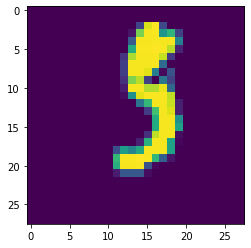

In [49]:
context = torch.zeros((1,1), dtype=torch.long, device=device)
result = decode(m.generate(context, max_new_tokens=783)[0].tolist())
img = np.reshape(result, (28, 28))
img[np.where(img==1000)] = 0.0 # positions considered as the end of 28*28 pixels
plt.imshow(img)
plt.show()